In [5]:
import numpy as np
import random
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import Tensor
from tqdm import tqdm
import time



In [6]:
class DifferentialEvolutionAlgorithm():
    def __init__(self,
                 num_epochs:int,
                 pop_size:int,
                 chrom_length:int,
                 value_ranges:list,
                 mutation_rate:float,
                 fitness_func, # Function Type,
                 crossover_rate = 0.8,
                 seed=42,
                 device="cpu"
                ):
        
        self.num_epochs = num_epochs
        self.pop_size = pop_size
        self.chrom_length = chrom_length
        self.device = device
        self.value_ranges = Tensor(value_ranges).to(self.device)
        self.mutation_rate = mutation_rate
        self.fitness_func = fitness_func
        self.seed = seed    
        self.crossover_rate = crossover_rate

        torch.manual_seed(seed=seed)

    def init_pop(self):
        """
        Initializes a matrix with random values from an uniform distribution
        """
        self.x_g = torch.rand(self.pop_size, self.chrom_length).to(self.device)
        # Denormalization process
        min_mat = self.value_ranges.T[0, :]
        max_mat = self.value_ranges.T[1,:]
        self.x_g = self.x_g * (max_mat - min_mat) + min_mat
        return

    def mutation(self):
        mutation_ind_indices_1 = torch.randint(low=0, high=self.pop_size, size=(1, self.pop_size)).to(self.device)
        mutation_ind_indices_2 = torch.randint(low=0, high=self.pop_size, size=(1, self.pop_size)).to(self.device)
        self.v_g = self.x_g + self.mutation_rate * \
              (self.x_g[mutation_ind_indices_1] - self.x_g[mutation_ind_indices_2])
        self.v_g = self.v_g.squeeze(dim=0)
        return
                
    def crossover(self):
        crossover_prob = torch.rand(self.pop_size, self.chrom_length).to(self.device)
        aleat_index = torch.randint(low=0, high=self.chrom_length, size=(1,self.pop_size))
        aleat_index_ohe = torch.zeros(aleat_index.size(1), aleat_index.max() + 1, dtype=torch.bool).to(self.device)
        self.u_g = self.x_g.clone()
        self.u_g[crossover_prob >= self.crossover_rate] = self.v_g[crossover_prob >= self.crossover_rate]
        self.u_g[aleat_index_ohe] = self.v_g[aleat_index_ohe]
        return

    def selection(self):
        self.fitness_x_g = self.fitness_func(self.x_g)
        self.fitness_u_g = self.fitness_func(self.u_g)
        replacement_indices = self.fitness_u_g > self.fitness_x_g
        self.x_g[replacement_indices] = self.u_g[replacement_indices]
        return
    
    def callback(self):
        ...
    
    
    def fit(self):
        self.init_pop()
        start_time = time.time()
        for epoch in tqdm(range(self.num_epochs)):
            self.mutation()
            self.crossover()
            self.selection()
        print("--- %s seconds ---" % (time.time() - start_time))
        return self.x_g



In [17]:
def schaffer_function(mat_x_y):
    x = mat_x_y[:, 0]
    y = mat_x_y[:, 1]
    g = 0.5 + (torch.pow((torch.sin( torch.sqrt( torch.pow(x, 2) + torch.pow(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (torch.pow(x, 2) + torch.pow(y, 2)))
    return g


de_alg = DifferentialEvolutionAlgorithm(
                                        num_epochs=1000,
                                        pop_size=100,
                                        chrom_length=2,
                                        value_ranges=[(-10,10), (-10,10)],
                                        mutation_rate=0.8,
                                        fitness_func=schaffer_function,
                                        device="cpu"
                                        )
best_solutions = de_alg.fit()

100%|██████████| 1000/1000 [00:00<00:00, 6613.80it/s]

--- 0.16862797737121582 seconds ---


  0%|          | 0/1000 [00:00<?, ?it/s]<ipython-input-6-4ab54bad633a>:50: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646703877/work/aten/src/ATen/mps/MPSFallback.mm:11.)
  self.u_g[crossover_prob >= self.crossover_rate] = self.v_g[crossover_prob >= self.crossover_rate]
100%|██████████| 1000/1000 [00:06<00:00, 146.81it/s]
/opt/homebrew/anaconda3/envs/deeplearning/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646703877/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


--- 6.812793970108032 seconds ---


Text(0.5, 0, 'z')

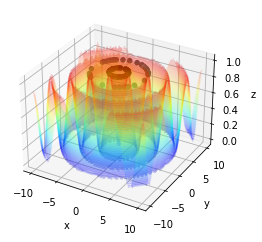

In [18]:
def schaffer_function(mat_x_y):
    x = mat_x_y[:, 0]
    y = mat_x_y[:, 1]
    g = 0.5 + (torch.pow((torch.sin( torch.sqrt( torch.pow(x, 2) + torch.pow(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (torch.pow(x, 2) + torch.pow(y, 2)))
    return g
device = "mps"
de_alg = DifferentialEvolutionAlgorithm(
                                        num_epochs=1000,
                                        pop_size=100,
                                        chrom_length=2,
                                        value_ranges=[(-10,10), (-10,10)],
                                        mutation_rate=0.8,
                                        fitness_func=schaffer_function,
                                        seed=1,
                                        device="mps"
                                        )
best_solutions = de_alg.fit()
def schaffer_function_plot(x,y):
    g = 0.5 + (torch.pow((torch.sin( torch.sqrt( torch.pow(x, 2) + torch.pow(y, 2)))), 2) - 0.5)/ \
        (1 + 0.001 * (torch.pow(x, 2) + torch.pow(y, 2)))
    return g

x_data = best_solutions[:, 0].cpu()
y_data = best_solutions[:, 1].cpu()
z_data = schaffer_function_plot(x_data, y_data).cpu()

x = torch.linspace(-10, 10, 50).cpu()
y = torch.linspace(-10, 10, 50).cpu()

X, Y = torch.meshgrid(x, y)
Z = schaffer_function_plot(X, Y)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='jet', alpha=0.2)
ax.scatter3D(x_data, y_data, z_data, c=z_data, cmap='binary', alpha=1)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
